### prepare


In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [2]:
import time
from typing import List
from pathlib import Path
import pickle

import hydra
from omegaconf import DictConfig

import gym
from gym.spaces import Box

import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import torch
import seaborn as sns
from cycler import cycler


from d3rlpy.algos import SAC
from d3rlpy.algos import DoubleDQN as DDQN
from d3rlpy.algos import CQL
from d3rlpy.algos import IQL
from d3rlpy.algos import BCQ
from d3rlpy.algos import DiscreteCQL
from d3rlpy.algos import DiscreteBCQ
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy, ConstantEpsilonGreedy
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import BaseHead
from scope_rl.policy import ContinuousGaussianHead as GaussianHead
from scope_rl.policy import DiscreteEpsilonGreedyHead as EpsilonGreedyHead
from scope_rl.policy import DiscreteSoftmaxHead as SoftmaxHead
from scope_rl.policy import OffPolicyLearning

from scope_rl.ope.online import visualize_on_policy_policy_value
from scope_rl.ope.online import calc_on_policy_policy_value

from scope_rl.utils import MinMaxActionScaler
from scope_rl.utils import OldGymAPIWrapper
from scope_rl.types import LoggedDataset

from experiments.utils import torch_seed, format_runtime

from basicgym import BasicEnv

from tutorial.function import train_behavior_policy
from tutorial.function import obtain_logged_dataset
from tutorial.function import train_candidate_policies
# from experiments.main import off_policy_evaluation
from tutorial.function import off_policy_evaluation

### function

In [3]:
def visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    estimators,
    ESTIMATORS,
    x_scales,
    x_label,
    yscale_log = False,
    xscale_log = False,
):

    color_dict = {
        "red": "#E24A33",
        "blue": "#348ABD",
        "purple": "#988ED5",
        "gray": "#777777",
        "green": "#8EBA42",
        "yellow": "#FBC15E",
        "pink": "#FFB5B8",
        "brown": "#8c564b",
        "light blue": "#17becf",
        "olive": "#bcbd22",
    }
    cd = color_dict

    plt.style.use("ggplot")
    colors = [cd["red"], cd["blue"], cd["purple"], cd["gray"], cd["yellow"], cd['green'], cd['pink'], cd['brown'], cd['light blue'], cd['olive']]
    # plt.rcParams["axes.prop_cycle"] = cycler(color=colors)
    markers = ["o", "v", "^", "s", "p", "P", "*", "h", "X", "D", "d"]
    # colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    n_colors = len(colors)

    log_dir="../tutorial/logs_epsilon=0.5/"

    metric_list = ['bias', 'variance', 'mse']

    for metric in metric_list:
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
        if metric =='bias':
            result_df = bias_result_df
        elif metric == 'variance':
            result_df = variance_result_df
        else:
            result_df = mse_result_df

        for i, estimator in enumerate(estimators):
            data = result_df[result_df['est']==estimator]
            data = data.query(f"({min(x_scales)}<= {x_label} <= {max(x_scales)})")
            ax.plot(
                np.array([200, 400, 800, 1600, 3200, 4800, 6400, 8000]),
                data[metric],
                color=colors[i],
                marker=markers[i],
                label=ESTIMATORS[i],
            )
            
            ax.legend(ESTIMATORS, loc="upper right", fontsize=20)

            ax.fill_between(
                np.array([200, 400, 800, 1600, 3200, 4800, 6400, 8000]),
                data['lower'],
                data['upper'],
                color=colors[i % n_colors],
                alpha=0.3,
                label='',
            )

        # title and legend
        ax.legend(loc="upper right", fontsize=20)
        # yaxis
        if yscale_log:
            ax.set_yscale("log")
        ax.set_ylabel(metric, fontsize=25)
        ax.tick_params(axis="y", labelsize=15)
        ax.yaxis.set_label_coords(-0.08, 0.5)
        # xaxis
        if xscale_log:
            ax.set_xscale("log")
        ax.set_xlabel(f"number of {x_label}", fontsize=25)
        ax.set_xticks(x_scales)
        ax.set_xticklabels(x_scales, fontsize=15)
        ax.xaxis.set_label_coords(0.5, -0.1)

        path_ = Path(log_dir + "results/fig")
        path_.mkdir(exist_ok=True, parents=True)
        save_path = Path(path_ / f"{metric}_result_fig_{x_label}_{ESTIMATORS}.png")
        fig.tight_layout()
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

In [4]:
x_scales=[200, 400, 800, 1600, 3200,4800, 6400, 8000]
x_label='n_trajectories'


In [5]:
# visualize(
#     bias_result_df,
#     variance_result_df,
#     mse_result_df,
#     ESTIMATORS=ESTIMATORS,
#     estimators=estimators,
#     x_scales=x_scales,
#     x_label=x_label,
#     # yscale_log=True,
#     # xscale_log=True,
# )

In [16]:
def main(
    variable_name,
    n_random_state,
    log_dir="../tutorial/logs/",
    behavior_tau = 1.0,
    candidate_epsilons = [1.0],
    behavior_sigma = 1.0,
    candidate_sigmas = [1.0],
    action_type = 'discrete',
):
    #discrete
    env_name="BasicEnv-discrete-v0"
    action_type='discrete'
    behavior_policy_name=f"ddqn_softmax_{behavior_tau}"
    candidate_policy_name=f"cql_eps_{candidate_epsilons[0]}"

    #continuous
    # env_name="BasicEnv-continuous-v0"
    # action_type='continuous'
    # behavior_policy_name=f"sac_gauss_{behavior_sigma}"
    # candidate_policy_name=f"cql_b1_gauss_{candidate_sigmas}"

    base_random_state=12345
    device="cuda:0" if torch.cuda.is_available() else "cpu"
    step_per_trajectory_list =  [5, 10, 20, 40, 60, 80, 100]
    step_per_trajectory = 10
    n_trajectories_list=[200, 400, 800, 1600, 3200, 4800, 6400, 8000]
    n_trajectories=1000
    n_actions_list = [2, 4, 6, 10, 12, 14]
    n_actions=5
    
    bias_df_list = []
    variance_df_list = []
    mse_df_list = []

    random_ = check_random_state(base_random_state)
    n_bootstrap_samples = 100
    alpha=0.05

    if variable_name == 'n_trajectories':
        variable_list = n_trajectories_list
    elif variable_name == 'n_actions':
        variable_list = n_actions_list
    elif variable_name == 'step_per_trajectory':
        variable_list = step_per_trajectory_list
    else:
        ValueError


    for variable in variable_list:

        if variable_name == 'n_trajectories':
            n_trajectories = variable
        elif variable_name == 'n_actions':
            n_actions == variable
        elif variable_name == 'step_per_trajectory':
            step_per_trajectory =variable

        env = BasicEnv(
            action_type=action_type, 
            n_actions=n_actions,
            random_state=base_random_state, 
            step_per_episode=step_per_trajectory,
        )

        behavior_policy = train_behavior_policy(
            env_name=env_name,
            env=env,
            behavior_sigma=behavior_sigma,
            behavior_tau=behavior_tau,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        train_logged_dataset, test_logged_dataset = obtain_logged_dataset(
            env_name=env_name,
            env=env,
            behavior_policy=behavior_policy,
            n_trajectories=n_trajectories,
            n_random_state=n_random_state,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        candidate_policies = train_candidate_policies(
            env_name=env_name,
            env=env,
            n_trajectories=n_trajectories,
            train_logged_dataset=train_logged_dataset,
            candidate_sigmas=candidate_sigmas,
            candidate_epsilons=candidate_epsilons,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        input_dict, policy_value_dict = off_policy_evaluation(
            env_name=env_name,
            env=env,
            n_trajectories=n_trajectories,
            test_logged_dataset=test_logged_dataset,
            candidate_policies=candidate_policies,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        input_dict_ = input_dict.get(
            behavior_policy_name=behavior_policy_name,
            dataset_id=0,
        )

        dict = {i : DataFrame() for i in input_dict_.keys()}
        bias_dict = {i : 0 for i in input_dict_.keys()}
        variance_dict = {i : 0 for i in input_dict_.keys()}
        mse_dict = {i : 0 for i in input_dict_.keys()}
        lower_bias = []
        upper_bias = []
        lower_variance = []
        upper_variance = []
        lower_mse = []
        upper_mse = []

        for dataset_id_ in range(n_random_state):
            for eval_policy in input_dict_.keys():
                dict[eval_policy] = pd.concat([dict[eval_policy] , DataFrame(policy_value_dict[behavior_policy_name][dataset_id_][eval_policy], index=[dataset_id_])])

        for eval_policy in input_dict_.keys():
            bias_dict[eval_policy] = abs(dict[eval_policy].mean(axis=0) - dict[eval_policy].mean(axis=0)['on_policy'])
            variance_dict[eval_policy] = dict[eval_policy].var(axis=0)
            mse_dict[eval_policy] = bias_dict[eval_policy]**2 + variance_dict[eval_policy]

        for estimator in dict[eval_policy].columns.values:
            samples = dict[eval_policy][estimator]
            samples = np.nan_to_num(samples, posinf=1e2)
            samples = np.clip(samples, 0.0, 1e2)
            boot_samples_bias = [
                np.mean(random_.choice(samples - dict[eval_policy].mean(axis=0)['on_policy'], size=samples.shape[0]))
                for i in range(n_bootstrap_samples)
            ]
            boot_samples_bias = list(map(abs, boot_samples_bias))
            boot_samples_variance = [
                np.var(random_.choice(samples, size=samples.shape[0]))
                for i in range(n_bootstrap_samples)
            ]
            boot_samples_mse = np.square(boot_samples_bias) + boot_samples_variance

            lower_bias.append(np.percentile(boot_samples_bias, 100 * (alpha / 2)))
            upper_bias.append(np.percentile(boot_samples_bias, 100 * (1.0 - alpha / 2)))
            lower_variance.append(np.percentile(boot_samples_variance, 100 * (alpha / 2)))
            upper_variance.append(np.percentile(boot_samples_variance, 100 * (1.0 - alpha / 2)))
            lower_mse.append(np.percentile(boot_samples_mse, 100 * (alpha / 2)))
            upper_mse.append(np.percentile(boot_samples_mse, 100 * (1.0 - alpha / 2)))


        bias_df = DataFrame(DataFrame(bias_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "bias"})
        bias_df['lower']=lower_bias
        bias_df['upper']=upper_bias
        bias_df[variable_name] = variable
        bias_df_list.append(bias_df)
        variance_df = DataFrame(DataFrame(variance_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "variance"})
        variance_df['lower']=lower_variance
        variance_df['upper']=upper_variance
        variance_df[variable_name] = variable
        variance_df_list.append(variance_df)
        mse_df = DataFrame(DataFrame(mse_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "mse"})
        mse_df['lower']=lower_mse
        mse_df['upper']=upper_mse
        mse_df[variable_name] = variable
        mse_df_list.append(mse_df)


    # aggregate all results 
    bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
    variance_result_df = pd.concat(variance_df_list).reset_index(level=0)
    mse_result_df = pd.concat(mse_df_list).reset_index(level=0)

    path_ = Path("logs" + f"/results/df")
    path_.mkdir(exist_ok=True, parents=True)
    path_bias = Path(path_ / f"bias_result_df_{variable_name}.pkl")
    path_variance = Path(path_ / f"variance_result_df_{variable_name}.pkl")
    path_mse = Path(path_ / f"mse_result_df_{variable_name}.pkl")

    with open(path_bias, "wb") as f:
        pickle.dump(bias_result_df, f)
    with open(path_variance, "wb") as f:
        pickle.dump(variance_result_df, f)
    with open(path_mse, "wb") as f:
        pickle.dump(mse_result_df, f)

    return bias_result_df, variance_result_df, mse_result_df


In [7]:
bias_result_df, variance_result_df, mse_result_df =main(
    variable_name = "n_trajectories",
    n_random_state = 2,
    log_dir="../tutorial/logs_epsilon=0.5/",
    behavior_tau = 0.0,
    candidate_epsilons = [0.5],
    behavior_sigma = 1.0,
    candidate_sigmas = [1.0],
    action_type = 'discrete',
)

### main

In [8]:
# # path_ = Path("logs_tau=0.0" + f"/results/df")
# path_ = Path("logs_epsilon=0.5" + f"/results/df")

# # variable_name='step_per_trajectory'
# variable_name='n_trajectories'
# # variable_name='n_actions'


# path_bias = Path(path_ / f"bias_result_df_{variable_name}.pkl")
# path_variance = Path(path_ / f"variance_result_df_{variable_name}.pkl")
# path_mse = Path(path_ / f"mse_result_df_{variable_name}.pkl")
# with open(path_bias, "rb") as f:
#     bias_result_df = pickle.load(f)
# with open(path_variance, "rb") as f:
#     variance_result_df = pickle.load(f)
# with open(path_mse, "rb") as f:
#     mse_result_df = pickle.load(f)

In [9]:
basic_estimators = ["DM", "TIS", "PDIS", "DR", "SNTIS", "SNPDIS", "SNDR"]
state_marginal_estimators = ["SMIS", "SMDR", "SMSNIS", "SMSNDR"]
state_action_marginal_estimators = ["SAMIS", "SAMDR", "SAMSNIS", "SAMSNDR"]
drl_estimators = ["DRL"]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]
all_estimators_name = basic_estimators_name + state_marginal_estimators_name + state_action_marginal_estimators_name + drl_estimators_name

In [17]:
bias_result_df, variance_result_df, mse_result_df =main(
    variable_name = "n_trajectories",
    n_random_state = 2,
    log_dir="../tutorial/logs/",
    behavior_tau = 5.0,
    candidate_epsilons = [0.5],
    behavior_sigma = 1.0,
    candidate_sigmas = [1.0],
    action_type = 'discrete',
)

2023-06-14 21:36.25 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230614213625
2023-06-14 21:36.25 [debug    ] Building model...
2023-06-14 21:36.25 [debug    ] Model has been built.
2023-06-14 21:36.25 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614213625/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-06-14 21:36.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614213625/model_100.pt
2023-06-14 21:36.25 [info     ] DoubleDQN_online_20230614213625: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0002988386154174805, 'time_environment_step': 5.8984756469726564e-05, 'time_step': 0.00037615299224853517, 'rollout_return': 0.5563464321780278, 'evaluation': 3.224955628871031} step=100
2023-06-14 21:36.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614213625/model_200.pt
2023-06-14 21:36.26 [info     ] DoubleDQN_online_20230614213625: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0002782034873962402, 'time_environment_step': 7.592201232910156e-05, 'time_sample_batch': 6.227731704711914e-05, 'time_algorithm_update': 0.0017983460426330567, 'loss': 0.038158467523753646, 'time_step': 0.0022487115859985353, 'rollout_return': 0.4113635387863982, 'evaluation': 3.0487185223605797} step=200
2023-06-14 21:36.26 [info    

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:39.30 [debug    ] RandomIterator is selected.
2023-06-14 21:39.30 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230614213930
2023-06-14 21:39.30 [debug    ] Building models...
2023-06-14 21:39.30 [debug    ] Models have been built.
2023-06-14 21:39.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230614213930/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-14 21:39.48 [info     ] DiscreteCQL_20230614213930: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0001111171007156372, 'time_algorithm_update': 0.0015891380071640015, 'loss': 1.6247214041113853, 'time_step': 0.0017930678367614745} step=10000
2023-06-14 21:39.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230614213930/model_10000.pt


[collect input data: behavior_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:39.48 [debug    ] RoundIterator is selected.
2023-06-14 21:39.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614213948
2023-06-14 21:39.48 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 21:39.48 [debug    ] Building models...
2023-06-14 21:39.48 [debug    ] Models have been built.
2023-06-14 21:39.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614213948/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-06-14 21:39.49 [info     ] DiscreteFQE_20230614213948: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.00012592077255249023, 'time_algorithm_update': 0.0022197842597961428, 'loss': 0.09568832442164421, 'time_step': 0.00240902304649353} step=40
2023-06-14 21:39.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614213948/model_40.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.160, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.329, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:39.49 [debug    ] RoundIterator is selected.
2023-06-14 21:39.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614213949
2023-06-14 21:39.49 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 21:39.49 [debug    ] Building models...
2023-06-14 21:39.49 [debug    ] Models have been built.
2023-06-14 21:39.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614213949/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-06-14 21:39.50 [info     ] DiscreteFQE_20230614213949: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.0001364171504974365, 'time_algorithm_update': 0.002220827341079712, 'loss': 0.05361178545281291, 'time_step': 0.0024809658527374266} step=40
2023-06-14 21:39.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614213949/model_40.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.140, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.313, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-06-14 21:39.51 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230614213951
2023-06-14 21:39.51 [debug    ] Building model...
2023-06-14 21:39.51 [debug    ] Model has been built.
2023-06-14 21:39.51 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614213951/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-06-14 21:39.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614213951/model_100.pt
2023-06-14 21:39.51 [info     ] DoubleDQN_online_20230614213951: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.000252072811126709, 'time_environment_step': 5.066156387329102e-05, 'time_step': 0.00031815290451049806, 'rollout_return': -0.007165581086363846, 'evaluation': 3.224955628871031} step=100
2023-06-14 21:39.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614213951/model_200.pt
2023-06-14 21:39.51 [info     ] DoubleDQN_online_20230614213951: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00028851032257080076, 'time_environment_step': 9.01174545288086e-05, 'time_sample_batch': 7.20071792602539e-05, 'time_algorithm_update': 0.001875593662261963, 'loss': 0.037104499451816084, 'time_step': 0.002365434169769287, 'rollout_return': 0.08831409053794034, 'evaluation': 3.0487185223605797} step=200
2023-06-14 21:39.51 [info     

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:42.51 [debug    ] RandomIterator is selected.
2023-06-14 21:42.51 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230614214251
2023-06-14 21:42.51 [debug    ] Building models...
2023-06-14 21:42.51 [debug    ] Models have been built.
2023-06-14 21:42.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230614214251/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-14 21:43.08 [info     ] DiscreteCQL_20230614214251: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00011295030117034912, 'time_algorithm_update': 0.0014850993394851684, 'loss': 1.6262145684719085, 'time_step': 0.0016944544315338134} step=10000
2023-06-14 21:43.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230614214251/model_10000.pt


[collect input data: behavior_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:43.08 [debug    ] RoundIterator is selected.
2023-06-14 21:43.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614214308
2023-06-14 21:43.08 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 21:43.08 [debug    ] Building models...
2023-06-14 21:43.08 [debug    ] Models have been built.
2023-06-14 21:43.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614214308/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-06-14 21:43.08 [info     ] DiscreteFQE_20230614214308: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00013543069362640381, 'time_algorithm_update': 0.001909106969833374, 'loss': 0.08931563887745142, 'time_step': 0.0021308243274688722} step=80
2023-06-14 21:43.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614214308/model_80.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.175, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.327, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:43.09 [debug    ] RoundIterator is selected.
2023-06-14 21:43.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614214309
2023-06-14 21:43.09 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 21:43.09 [debug    ] Building models...
2023-06-14 21:43.09 [debug    ] Models have been built.
2023-06-14 21:43.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614214309/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-06-14 21:43.09 [info     ] DiscreteFQE_20230614214309: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00015426278114318847, 'time_algorithm_update': 0.001986953616142273, 'loss': 0.05055646756663919, 'time_step': 0.0022149205207824705} step=80
2023-06-14 21:43.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614214309/model_80.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.209, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.344, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-06-14 21:43.11 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230614214311
2023-06-14 21:43.11 [debug    ] Building model...
2023-06-14 21:43.11 [debug    ] Model has been built.
2023-06-14 21:43.11 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614214311/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-06-14 21:43.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614214311/model_100.pt
2023-06-14 21:43.11 [info     ] DoubleDQN_online_20230614214311: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0003201079368591309, 'time_environment_step': 5.9409141540527345e-05, 'time_step': 0.0003981328010559082, 'rollout_return': 0.2571503005773691, 'evaluation': 3.224955628871031} step=100
2023-06-14 21:43.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614214311/model_200.pt
2023-06-14 21:43.11 [info     ] DoubleDQN_online_20230614214311: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00024657487869262696, 'time_environment_step': 6.957054138183594e-05, 'time_sample_batch': 5.2132606506347655e-05, 'time_algorithm_update': 0.0011835718154907227, 'loss': 0.041027139965444805, 'time_step': 0.0015821242332458496, 'rollout_return': 0.6778204206989854, 'evaluation': 3.0487185223605797} step=200
2023-06-14 21:43.11 [info   

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:46.39 [debug    ] RandomIterator is selected.
2023-06-14 21:46.39 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230614214639
2023-06-14 21:46.39 [debug    ] Building models...
2023-06-14 21:46.39 [debug    ] Models have been built.
2023-06-14 21:46.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230614214639/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-14 21:46.57 [info     ] DiscreteCQL_20230614214639: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00011971688270568848, 'time_algorithm_update': 0.0015671251773834228, 'loss': 1.6265268805146218, 'time_step': 0.0017916544675827025} step=10000
2023-06-14 21:46.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230614214639/model_10000.pt


[collect input data: behavior_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:46.57 [debug    ] RoundIterator is selected.
2023-06-14 21:46.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614214657
2023-06-14 21:46.57 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 21:46.57 [debug    ] Building models...
2023-06-14 21:46.57 [debug    ] Models have been built.
2023-06-14 21:46.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614214657/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-06-14 21:46.58 [info     ] DiscreteFQE_20230614214657: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.0001425430178642273, 'time_algorithm_update': 0.0018270015716552734, 'loss': 0.07793388166464865, 'time_step': 0.002038326859474182} step=160
2023-06-14 21:46.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614214657/model_160.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.204, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.337, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:46.59 [debug    ] RoundIterator is selected.
2023-06-14 21:46.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614214659
2023-06-14 21:46.59 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 21:46.59 [debug    ] Building models...
2023-06-14 21:46.59 [debug    ] Models have been built.
2023-06-14 21:46.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614214659/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-06-14 21:46.59 [info     ] DiscreteFQE_20230614214659: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00014613568782806396, 'time_algorithm_update': 0.0020334646105766296, 'loss': 0.05282472942490131, 'time_step': 0.0022538274526596068} step=160
2023-06-14 21:46.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614214659/model_160.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.191, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.348, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-06-14 21:47.01 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230614214701
2023-06-14 21:47.01 [debug    ] Building model...
2023-06-14 21:47.01 [debug    ] Model has been built.
2023-06-14 21:47.01 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614214701/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-06-14 21:47.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614214701/model_100.pt
2023-06-14 21:47.01 [info     ] DoubleDQN_online_20230614214701: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00024150848388671876, 'time_environment_step': 5.020856857299805e-05, 'time_step': 0.00030693531036376956, 'rollout_return': 0.5787126841186548, 'evaluation': 3.224955628871031} step=100
2023-06-14 21:47.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614214701/model_200.pt
2023-06-14 21:47.01 [info     ] DoubleDQN_online_20230614214701: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00027658939361572263, 'time_environment_step': 7.17616081237793e-05, 'time_sample_batch': 5.582094192504883e-05, 'time_algorithm_update': 0.0015955543518066406, 'loss': 0.04215649904683232, 'time_step': 0.0020337486267089843, 'rollout_return': 0.8868888316481038, 'evaluation': 3.0487185223605797} step=200
2023-06-14 21:47.01 [info     

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:51.08 [debug    ] RandomIterator is selected.
2023-06-14 21:51.08 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230614215108
2023-06-14 21:51.08 [debug    ] Building models...
2023-06-14 21:51.08 [debug    ] Models have been built.
2023-06-14 21:51.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230614215108/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-14 21:51.27 [info     ] DiscreteCQL_20230614215108: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00012547061443328857, 'time_algorithm_update': 0.0016361936330795289, 'loss': 1.626702450478077, 'time_step': 0.0018724574327468873} step=10000
2023-06-14 21:51.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230614215108/model_10000.pt


[collect input data: behavior_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:51.28 [debug    ] RoundIterator is selected.
2023-06-14 21:51.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614215128
2023-06-14 21:51.28 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 21:51.28 [debug    ] Building models...
2023-06-14 21:51.28 [debug    ] Models have been built.
2023-06-14 21:51.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614215128/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/320 [00:00<?, ?it/s]

2023-06-14 21:51.28 [info     ] DiscreteFQE_20230614215128: epoch=1 step=320 epoch=1 metrics={'time_sample_batch': 0.00013721808791160582, 'time_algorithm_update': 0.001693195104598999, 'loss': 0.05733733639935963, 'time_step': 0.001906132698059082} step=320
2023-06-14 21:51.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614215128/model_320.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.196, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.374, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:51.30 [debug    ] RoundIterator is selected.
2023-06-14 21:51.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614215130
2023-06-14 21:51.30 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 21:51.30 [debug    ] Building models...
2023-06-14 21:51.30 [debug    ] Models have been built.
2023-06-14 21:51.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614215130/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/320 [00:00<?, ?it/s]

2023-06-14 21:51.31 [info     ] DiscreteFQE_20230614215130: epoch=1 step=320 epoch=1 metrics={'time_sample_batch': 0.00014963075518608092, 'time_algorithm_update': 0.0018928594887256621, 'loss': 0.04202840928337537, 'time_step': 0.00213378369808197} step=320
2023-06-14 21:51.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614215130/model_320.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.176, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.353, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-06-14 21:51.33 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230614215133
2023-06-14 21:51.33 [debug    ] Building model...
2023-06-14 21:51.33 [debug    ] Model has been built.
2023-06-14 21:51.33 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614215133/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-06-14 21:51.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614215133/model_100.pt
2023-06-14 21:51.33 [info     ] DoubleDQN_online_20230614215133: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0002648544311523438, 'time_environment_step': 6.147384643554687e-05, 'time_step': 0.0003451395034790039, 'rollout_return': -0.10018586954404278, 'evaluation': 3.224955628871031} step=100
2023-06-14 21:51.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614215133/model_200.pt
2023-06-14 21:51.33 [info     ] DoubleDQN_online_20230614215133: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00032813549041748046, 'time_environment_step': 8.214235305786132e-05, 'time_sample_batch': 6.640911102294922e-05, 'time_algorithm_update': 0.001736295223236084, 'loss': 0.03516243953257799, 'time_step': 0.002253720760345459, 'rollout_return': 0.4779614793358543, 'evaluation': 3.0487185223605797} step=200
2023-06-14 21:51.33 [info     ]

[obtain_trajectories]:   0%|          | 0/4800 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/4800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/4800 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:55.34 [debug    ] RandomIterator is selected.
2023-06-14 21:55.34 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230614215534
2023-06-14 21:55.34 [debug    ] Building models...
2023-06-14 21:55.34 [debug    ] Models have been built.
2023-06-14 21:55.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230614215534/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-14 21:55.51 [info     ] DiscreteCQL_20230614215534: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00011379823684692383, 'time_algorithm_update': 0.0014458492279052733, 'loss': 1.625804824757576, 'time_step': 0.0016568495750427245} step=10000
2023-06-14 21:55.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230614215534/model_10000.pt


[collect input data: behavior_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:55.51 [debug    ] RoundIterator is selected.
2023-06-14 21:55.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614215551
2023-06-14 21:55.51 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 21:55.51 [debug    ] Building models...
2023-06-14 21:55.51 [debug    ] Models have been built.
2023-06-14 21:55.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614215551/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/480 [00:00<?, ?it/s]

2023-06-14 21:55.52 [info     ] DiscreteFQE_20230614215551: epoch=1 step=480 epoch=1 metrics={'time_sample_batch': 0.00015059461196263632, 'time_algorithm_update': 0.0017604852716128032, 'loss': 0.04721806489590866, 'time_step': 0.0020051866769790648} step=480
2023-06-14 21:55.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614215551/model_480.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.181, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.296, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 21:55.54 [debug    ] RoundIterator is selected.
2023-06-14 21:55.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614215554
2023-06-14 21:55.54 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 21:55.54 [debug    ] Building models...
2023-06-14 21:55.54 [debug    ] Models have been built.
2023-06-14 21:55.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614215554/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/480 [00:00<?, ?it/s]

2023-06-14 21:55.55 [info     ] DiscreteFQE_20230614215554: epoch=1 step=480 epoch=1 metrics={'time_sample_batch': 0.00014319370190302532, 'time_algorithm_update': 0.001787876586119334, 'loss': 0.038664076523855326, 'time_step': 0.002018780012925466} step=480
2023-06-14 21:55.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614215554/model_480.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.215, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.366, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-06-14 21:55.57 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230614215557
2023-06-14 21:55.57 [debug    ] Building model...
2023-06-14 21:55.57 [debug    ] Model has been built.
2023-06-14 21:55.57 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614215557/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-06-14 21:55.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614215557/model_100.pt
2023-06-14 21:55.57 [info     ] DoubleDQN_online_20230614215557: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0003106284141540527, 'time_environment_step': 6.39796257019043e-05, 'time_step': 0.0003956151008605957, 'rollout_return': 0.1443800266681541, 'evaluation': 3.224955628871031} step=100
2023-06-14 21:55.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614215557/model_200.pt
2023-06-14 21:55.58 [info     ] DoubleDQN_online_20230614215557: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003237128257751465, 'time_environment_step': 6.316423416137695e-05, 'time_sample_batch': 5.134820938110352e-05, 'time_algorithm_update': 0.0011904811859130859, 'loss': 0.037248344849795105, 'time_step': 0.0016579818725585937, 'rollout_return': 0.30686822286854226, 'evaluation': 3.0487185223605797} step=200
2023-06-14 21:55.58 [info     ]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 22:00.25 [debug    ] RandomIterator is selected.
2023-06-14 22:00.25 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230614220025
2023-06-14 22:00.25 [debug    ] Building models...
2023-06-14 22:00.25 [debug    ] Models have been built.
2023-06-14 22:00.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230614220025/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-14 22:00.42 [info     ] DiscreteCQL_20230614220025: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00011463370323181153, 'time_algorithm_update': 0.0014756765842437744, 'loss': 1.6287722844600678, 'time_step': 0.001687208104133606} step=10000
2023-06-14 22:00.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230614220025/model_10000.pt


[collect input data: behavior_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 22:00.43 [debug    ] RoundIterator is selected.
2023-06-14 22:00.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614220043
2023-06-14 22:00.43 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 22:00.43 [debug    ] Building models...
2023-06-14 22:00.43 [debug    ] Models have been built.
2023-06-14 22:00.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614220043/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/640 [00:00<?, ?it/s]

2023-06-14 22:00.44 [info     ] DiscreteFQE_20230614220043: epoch=1 step=640 epoch=1 metrics={'time_sample_batch': 0.0001372605562210083, 'time_algorithm_update': 0.0013882394880056382, 'loss': 0.043007645951001906, 'time_step': 0.0015935041010379791} step=640
2023-06-14 22:00.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614220043/model_640.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.169, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.341, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 22:00.46 [debug    ] RoundIterator is selected.
2023-06-14 22:00.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614220046
2023-06-14 22:00.46 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 22:00.46 [debug    ] Building models...
2023-06-14 22:00.46 [debug    ] Models have been built.
2023-06-14 22:00.46 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614220046/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/640 [00:00<?, ?it/s]

2023-06-14 22:00.47 [info     ] DiscreteFQE_20230614220046: epoch=1 step=640 epoch=1 metrics={'time_sample_batch': 0.00013413317501544952, 'time_algorithm_update': 0.0014206979423761368, 'loss': 0.037144291473669, 'time_step': 0.0016214817762374878} step=640
2023-06-14 22:00.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614220046/model_640.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.234, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.348, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-06-14 22:00.49 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230614220049
2023-06-14 22:00.49 [debug    ] Building model...
2023-06-14 22:00.49 [debug    ] Model has been built.
2023-06-14 22:00.49 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614220049/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-06-14 22:00.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614220049/model_100.pt
2023-06-14 22:00.49 [info     ] DoubleDQN_online_20230614220049: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.000265657901763916, 'time_environment_step': 5.4972171783447264e-05, 'time_step': 0.00033714056015014647, 'rollout_return': 0.20312214376184917, 'evaluation': 3.224955628871031} step=100
2023-06-14 22:00.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230614220049/model_200.pt
2023-06-14 22:00.49 [info     ] DoubleDQN_online_20230614220049: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0002647972106933594, 'time_environment_step': 5.76019287109375e-05, 'time_sample_batch': 4.452705383300781e-05, 'time_algorithm_update': 0.0009958314895629882, 'loss': 0.041205854378640654, 'time_step': 0.0013885021209716797, 'rollout_return': 0.06766727584150282, 'evaluation': 3.0487185223605797} step=200
2023-06-14 22:00.50 [info    

[obtain_trajectories]:   0%|          | 0/8000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/8000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/8000 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 22:05.04 [debug    ] RandomIterator is selected.
2023-06-14 22:05.04 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230614220504
2023-06-14 22:05.04 [debug    ] Building models...
2023-06-14 22:05.04 [debug    ] Models have been built.
2023-06-14 22:05.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230614220504/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-14 22:05.20 [info     ] DiscreteCQL_20230614220504: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00010666441917419433, 'time_algorithm_update': 0.0013543673992156982, 'loss': 1.6269011665225028, 'time_step': 0.001551349425315857} step=10000
2023-06-14 22:05.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230614220504/model_10000.pt


[collect input data: behavior_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 22:05.20 [debug    ] RoundIterator is selected.
2023-06-14 22:05.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614220520
2023-06-14 22:05.20 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 22:05.20 [debug    ] Building models...
2023-06-14 22:05.20 [debug    ] Models have been built.
2023-06-14 22:05.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614220520/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/800 [00:00<?, ?it/s]

2023-06-14 22:05.23 [info     ] DiscreteFQE_20230614220520: epoch=1 step=800 epoch=1 metrics={'time_sample_batch': 0.00018176764249801635, 'time_algorithm_update': 0.002308942973613739, 'loss': 0.042406215256778526, 'time_step': 0.0025870227813720704} step=800
2023-06-14 22:05.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614220520/model_800.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.205, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.369, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-14 22:05.25 [debug    ] RoundIterator is selected.
2023-06-14 22:05.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230614220525
2023-06-14 22:05.25 [debug    ] Fitting scaler...              scaler=min_max
2023-06-14 22:05.25 [debug    ] Building models...
2023-06-14 22:05.25 [debug    ] Models have been built.
2023-06-14 22:05.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230614220525/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/800 [00:00<?, ?it/s]

2023-06-14 22:05.27 [info     ] DiscreteFQE_20230614220525: epoch=1 step=800 epoch=1 metrics={'time_sample_batch': 0.0001293596625328064, 'time_algorithm_update': 0.0013653481006622315, 'loss': 0.0419685703527648, 'time_step': 0.0015664580464363098} step=800
2023-06-14 22:05.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230614220525/model_800.pt


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.222, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/100 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.306, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
# ESTIMATORS=["TIS", "PDIS"]
# estimators=["tis", "pdis"]
# ESTIMATORS=["DM", "TIS"]
# estimators=["dm", "tis"]
ESTIMATORS=basic_estimators
estimators=basic_estimators_name
x_scales=[200, 400, 800, 1600, 3200,4800, 6400, 8000]
x_label='n_trajectories'

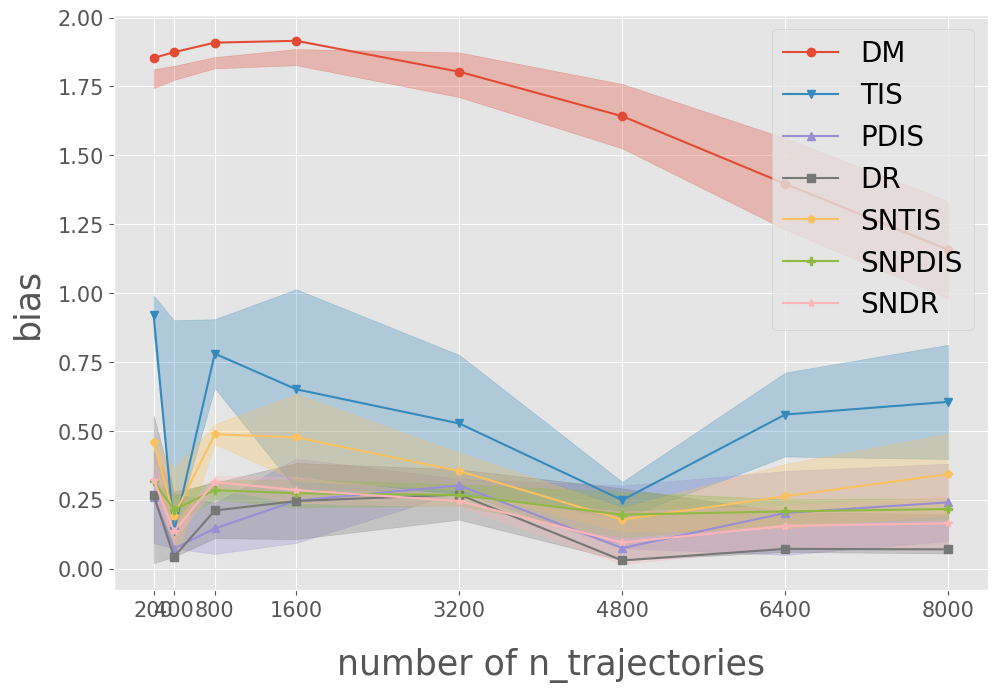

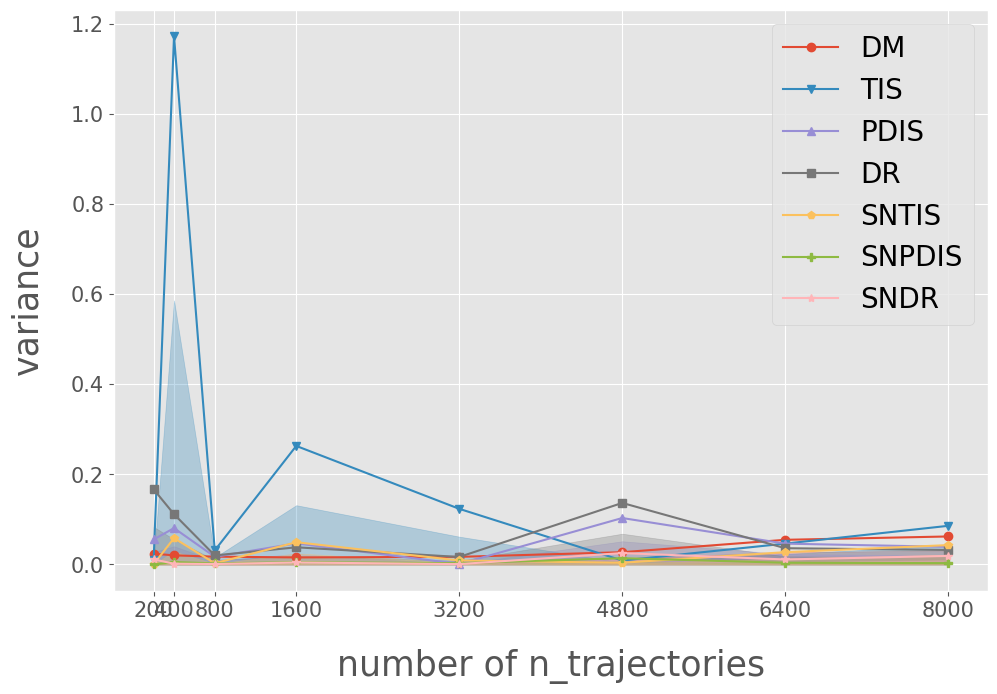

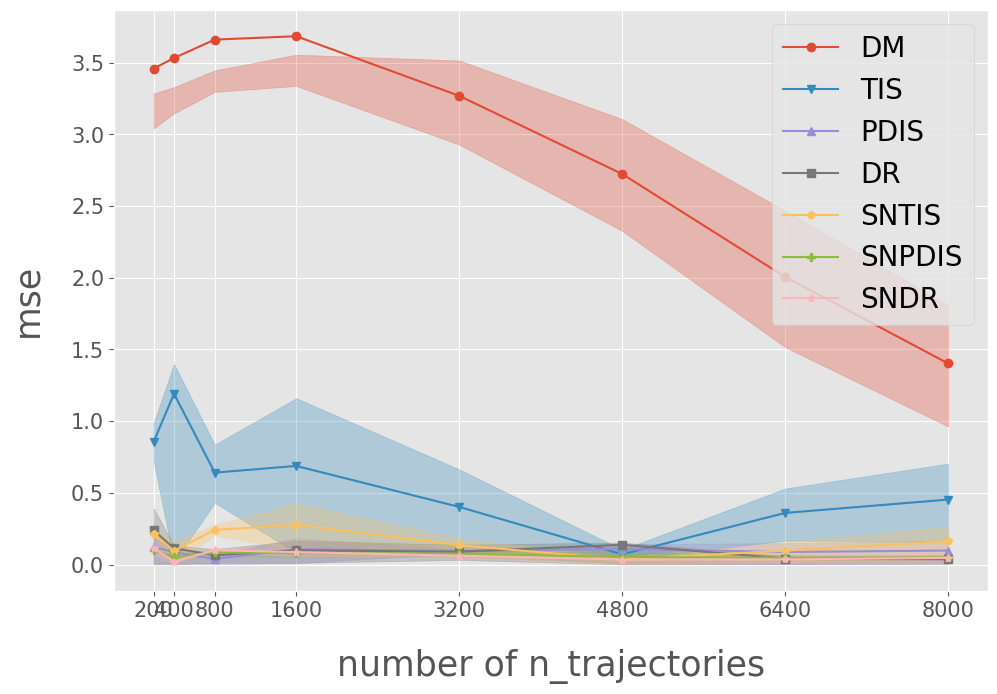

In [18]:
visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    ESTIMATORS=ESTIMATORS,
    estimators=estimators,
    x_scales=x_scales,
    x_label=x_label,
    # yscale_log=True,
    # xscale_log=True,
)